# House Rent Data Regression/Auto ML

Our dataset [Kaggle Link](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset) has information on 4700+ houses available for renting in India. We will use the dataset to create a regression model to predict rent prices. The tools we will use for modeling are scikit learn, LightGBM and AutoML (PyCaret). 

# Step 1: Import Common Modules/Libraries & the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns


In [2]:
#from google.colab import drive

#drive.mount('/content/gdrive')

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/House_Rent_Dataset.csv')

The dataset consists of 12 columns, for our purposes there are 11 features and one target variable (Rent) 

In [4]:
df.shape

(4746, 12)

In [5]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


Aside from Rent, there are three numerical columns: size (sq ft), bathroom (# bathrooms), BHK (# of bedroom, hall, kitchen)

In [6]:
df.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


# Step 2: Feature Engineering

Note the (Floor) feature has numeric data but is currently a string, we will use regex to extract the numerical data from the columns. High rise apartments are typically expensive, so it's reasonable that the floor an apartment lies on will have predictive power on rent price.  Note the structure of the data is apartment floor (out of) total number of floors. We will extract the apartmen floor and total number of floors. There are a couple of terms (ground/upper/lower) that we will convert to numbers as well, we will assume ground/lower = 1 and upper is the max number of floors for the apartment building

In [7]:
df['Floor'].head()

0    Ground out of 2
1         1 out of 3
2         1 out of 3
3         1 out of 2
4         1 out of 2
Name: Floor, dtype: object

In [8]:
import re 
first_part_floor = []
second_part_floor = []
for i in df['Floor']:
    first_part_floor.append(i.split(" ")[0])
    second_part_floor.append(i.split(" ")[-1])

In [9]:
for i in range(0, len(first_part_floor)):
    if first_part_floor[i] == 'Upper':
        first_part_floor[i] = second_part_floor[i]
    elif first_part_floor[i] == "Ground":
        first_part_floor[i] = '1'
    elif first_part_floor[i] == 'Lower':
        first_part_floor[i] = '1'
    else:
        pass

In [10]:
for i in range(0, len(second_part_floor)):
    if second_part_floor[i] == 'Ground':
        second_part_floor[i] = '1'
    else:
        pass

In [11]:
df['first_part_floor'] = first_part_floor
df['second_part_floor'] = second_part_floor

We now have 14 columns, we will delete (Posted On), the original (Floor) and (Area Locality) columns. Someone with more knowledge of Indian localities may be able to transform the field from its highly cardinal state into something more useful but there are only 4700 rows and 2235 differnt localities.  We will convert the new floor features to numbers as well. Finally we will create a (relation to top) variable that will be equal to apartment floor / total number of apartment floors.

In [12]:
non_numeric_cols = list(df.select_dtypes('object').columns)
non_numeric_cols

['Posted On',
 'Floor',
 'Area Type',
 'Area Locality',
 'City',
 'Furnishing Status',
 'Tenant Preferred',
 'Point of Contact',
 'first_part_floor',
 'second_part_floor']

In [13]:
for col in non_numeric_cols:
    print(col + " # unique instances: " + str(len(df[col].unique())))
    print('------------------')

Posted On # unique instances: 81
------------------
Floor # unique instances: 480
------------------
Area Type # unique instances: 3
------------------
Area Locality # unique instances: 2235
------------------
City # unique instances: 6
------------------
Furnishing Status # unique instances: 3
------------------
Tenant Preferred # unique instances: 3
------------------
Point of Contact # unique instances: 3
------------------
first_part_floor # unique instances: 51
------------------
second_part_floor # unique instances: 66
------------------


In [14]:
df = df.drop(columns=['Posted On', 'Area Locality', 'Floor'])

In [15]:
df.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,first_part_floor,second_part_floor
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,1,2
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2


In [16]:
df['first_part_floor'] = df['first_part_floor'].astype('int')
df['second_part_floor'] = df['second_part_floor'].astype('int')

In [17]:
df['relation_to_top'] = df['first_part_floor'] / df['second_part_floor']

We'll now take a look at the remaining non numeric columns to assess what to do with rare labels

In [18]:
non_numeric_cols = list(df.select_dtypes('object').columns)
non_numeric_cols

['Area Type',
 'City',
 'Furnishing Status',
 'Tenant Preferred',
 'Point of Contact']

In [19]:
for col in non_numeric_cols:
    print(df[col].value_counts())
    print('---------------------')

Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64
---------------------
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
Name: City, dtype: int64
---------------------
Semi-Furnished    2251
Unfurnished       1815
Furnished          680
Name: Furnishing Status, dtype: int64
---------------------
Bachelors/Family    3444
Bachelors            830
Family               472
Name: Tenant Preferred, dtype: int64
---------------------
Contact Owner      3216
Contact Agent      1529
Contact Builder       1
Name: Point of Contact, dtype: int64
---------------------


Two features, (Area Type) & (Point of Contact) have extremely rare features with 2 and 1 instance respectively. We'll throw these datapoints out as they make up less than .1% of the rows

In [20]:
df = df[df['Area Type'] != 'Built Area']
df = df[df['Point of Contact'] != 'Contact Builder']

In [21]:
for col in non_numeric_cols:
    print(df[col].value_counts())
    print('---------------------')

Super Area     2445
Carpet Area    2298
Name: Area Type, dtype: int64
---------------------
Mumbai       972
Chennai      890
Bangalore    886
Hyderabad    866
Delhi        605
Kolkata      524
Name: City, dtype: int64
---------------------
Semi-Furnished    2251
Unfurnished       1813
Furnished          679
Name: Furnishing Status, dtype: int64
---------------------
Bachelors/Family    3441
Bachelors            830
Family               472
Name: Tenant Preferred, dtype: int64
---------------------
Contact Owner    3214
Contact Agent    1529
Name: Point of Contact, dtype: int64
---------------------


# Duplicate Dataset for AutoML

For the non-AutoML models we will utilize ordered integer encoding vs. using dummy variables. For the AutoML models we will just feed the model the categorical variables. For this reason we will make a copy of the dataset to use in the later AutoML exercise. There is a Feature-Engine Library that can do it for you, but since it's having errors due to some of the other imports in this notebook we'll do it manually. 

In [22]:
df_auto = df.copy()

In [23]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(df, df['Rent'], test_size=0.25, random_state=101)

In [24]:
#!pip install feature_engine

There is definitely a difference between average rent and the categorical features, so we should get better predictability with ordinal ordering. 

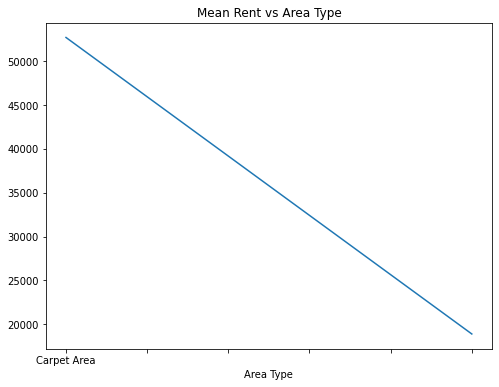

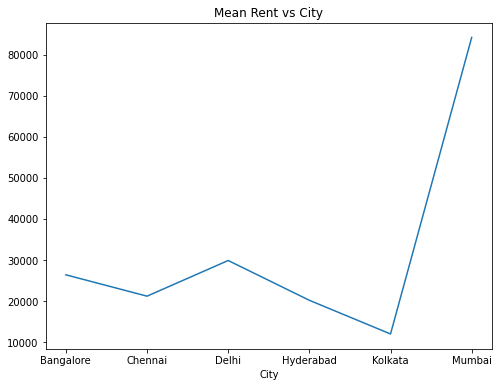

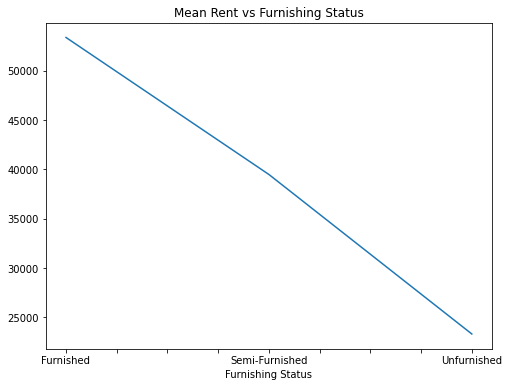

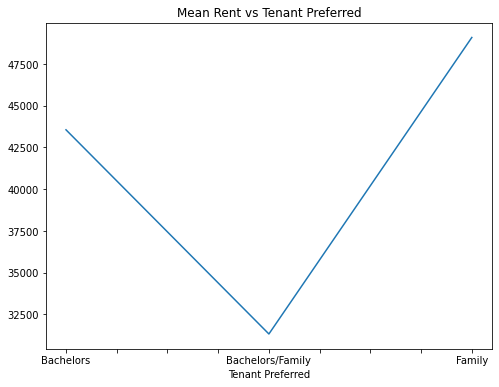

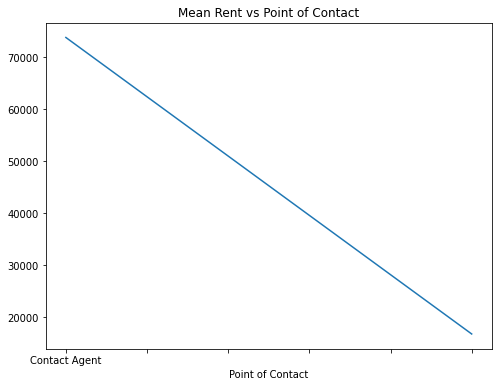

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

for feat in non_numeric_cols:
    fig = plt.figure()
    fig = Xtrain.groupby([feat])['Rent'].mean().plot()
    fig.set_title('Mean Rent vs {}'.format(feat))
    plt.show()

In [26]:
for col in non_numeric_cols:
    ordered_labels = Xtrain.groupby([col])['Rent'].mean().sort_values().index
    ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}
    Xtrain[col] = Xtrain[col].map(ordinal_mapping)
    Xtest[col] = Xtest[col].map(ordinal_mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
Xtrain.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,first_part_floor,second_part_floor,relation_to_top
2985,3,27000,1050,1,4,0,2,2,1,1,4,0.25
332,1,6500,400,0,0,0,0,1,0,1,1,1.00
26,1,5300,355,1,0,1,0,1,1,1,1,1.00
718,1,8500,550,0,5,1,0,1,0,3,5,0.60
4221,2,12500,1315,0,1,1,0,2,0,1,2,0.50


Our final step before creating the models will be scaling the data using min_max scaling so that the features will be on the same order of magnitude. 

In [28]:
Xtrain = Xtrain.drop(columns=['Rent'])
Xtest = Xtest.drop(columns=['Rent'])

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
min_max = MinMaxScaler()

In [31]:
min_max.fit(Xtrain)

Xtrain = min_max.transform(Xtrain)
Xtest = min_max.transform(Xtest)

In [32]:
min_max_target = MinMaxScaler()
ytrain = min_max_target.fit_transform(np.array(ytrain).reshape(-1, 1))
ytest = min_max_target.transform(np.array(ytest).reshape(-1, 1))

# Step 3: Scikit Learn Modeling 


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score

Importing Light GBM

In [34]:
#instructions from: https://www.kaggle.com/code/slavikonnikov/lightgbm-gpu-baseline-model-for-google-colab
# After running
#uncomment next line
#! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
#uncomment next line
#! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    

In [35]:
import lightgbm as lgb 

Linear Regression

In [36]:
lr = LinearRegression()

lr.fit(Xtrain, ytrain)
ytrain_pred = lr.predict(Xtrain)
ytest_pred = lr.predict(Xtest)

In [37]:
#training set mean squared error
mean_squared_error(ytrain, ytrain_pred)

0.0004009922119248773

In [38]:
r2_score(ytrain, ytrain_pred)

0.2697689994884659

In [39]:
stats_log = []
error = mean_squared_error(ytest, ytest_pred)
r2 = r2_score(ytest, ytest_pred)
stats_log.append(['Lin. Reg.', error, r2])
print('Linear Regression MSE: ', str(error), ' R2: ', str(r2))

Linear Regression MSE:  0.0001816443807955096  R2:  0.47605300494467695


In [40]:
rf = RandomForestRegressor()

rf.fit(Xtrain, ytrain)
ytrain_pred = rf.predict(Xtrain)
ytest_pred = rf.predict(Xtest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
error = mean_squared_error(ytest, ytest_pred)
r2 = r2_score(ytest, ytest_pred)
stats_log.append(['Ran. Forest', error, r2])
print('Random Forest MSE: ', str(error), ' R2: ', str(r2))

Random Forest MSE:  0.00019844397580601108  R2:  0.4275951485257228


In [42]:
ada = AdaBoostRegressor()

ada.fit(Xtrain, ytrain)
ytrain_pred = ada.predict(Xtrain)
ytest_pred = ada.predict(Xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [43]:
error = mean_squared_error(ytest, ytest_pred)
r2 = r2_score(ytest, ytest_pred)
stats_log.append(['AdaBoost', error, r2])
print('AdaBoost MSE: ', str(error), ' R2: ', str(r2))

AdaBoost MSE:  0.0002342984043359043  R2:  0.32417427745120286


In [44]:
lgbr = lgb.LGBMRegressor()

lgbr.fit(Xtrain, ytrain)
ytrain_pred = lgbr.predict(Xtrain)
ytest_pred = lgbr.predict(Xtest)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 3557, number of used features: 11
[LightGBM] [Info] Start training from score 0.009737


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [45]:
error = mean_squared_error(ytest, ytest_pred)
r2 = r2_score(ytest, ytest_pred)
stats_log.append(['LightGBM', error, r2])
print('Light GBM MSE: ', str(error), ' R2: ', str(r2))

Light GBM MSE:  0.00013721642676186725  R2:  0.6042039166901306


In [46]:
vals = []
names = []
for item in stats_log:
    vals.append(item[2])
    names.append(item[0])

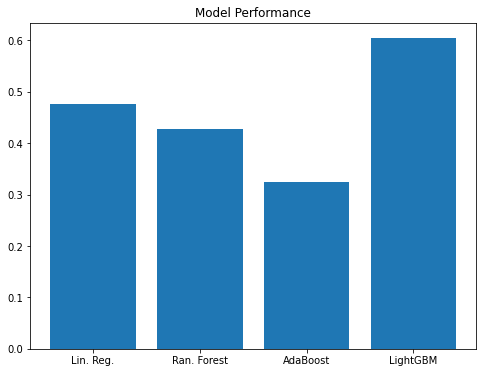

In [47]:
plt.bar(names, vals)
plt.title('Model Performance')
plt.show()


In [48]:
#uncomment next line 
#!pip install pycaret
#!pip install numba==0.53

# Step 4: AutoML with PyCaret

In [49]:
import pycaret as pycaret

In [50]:
from pycaret.regression import *

In [51]:
#requirement for pycaret, uncomment next line 
#!pip install scikit-learn==0.23.2

In [52]:
model = setup(data=df_auto, target='Rent')

,Description,Value
0,session_id,7731
1,Target,Rent
2,Original Data,"(4743, 12)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3320, 31)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='Rent',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='m...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
              

Bayesian Ridge Regression has the highest R2, LightGBM is performing much worse than our original test, we'll dive in and see what's going on.

In [53]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,20047.4904,5.089751e+09,53329.6781,0.5320,0.9468,0.8739,0.022
ridge,Ridge Regression,19908.3710,5.092192e+09,53335.7485,0.5316,0.9464,0.8622,0.029
llar,Lasso Least Angle Regression,19828.7865,5.094703e+09,53359.6549,0.5312,0.9607,0.8539,0.019
lasso,Lasso Regression,19893.1637,5.096248e+09,53387.3884,0.5304,0.9515,0.8602,0.064
lr,Linear Regression,19894.4445,5.096621e+09,53392.6411,0.5302,0.9642,0.8602,0.562
lar,Least Angle Regression,20355.6477,5.133844e+09,53686.2921,0.5243,0.9633,0.8998,0.021
lightgbm,Light Gradient Boosting Machine,14556.2618,5.056967e+09,54479.6629,0.4888,0.4439,0.3852,0.426
omp,Orthogonal Matching Pursuit,23037.4197,5.290928e+09,55849.9358,0.4711,0.9650,1.0797,0.016
en,Elastic Net,21913.5326,5.426152e+09,57153.1666,0.4455,0.8879,0.8807,0.039
et,Extra Trees Regressor,14459.9120,5.228348e+09,56032.3574,0.4038,0.4439,0.3876,1.201


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
INFO:logs:compare_models() succesfully completed......................................


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

We see taht the variation between R2 scores in the folds varies signficantly, it looks like we got a randomly good test set on our original test. This shows that K-fold should probably be a preferred method for testing models. We'll see if we can tune LightGBM to perform better. 

In [54]:
lightgb = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12448.9185,1.213209e+09,34831.1434,0.5942,0.4060,0.3723
1,13204.3269,1.584813e+09,39809.7094,0.4439,0.4475,0.3792
2,16630.3885,2.891674e+09,53774.2854,0.5390,0.4768,0.4282
3,16176.5022,4.062944e+09,63741.2302,0.4547,0.4861,0.3875
4,12051.2222,8.049897e+08,28372.3412,0.4292,0.4394,0.3799
5,15727.1340,2.404176e+09,49032.3924,0.2946,0.4680,0.4634
6,23002.2078,3.499191e+10,187061.2591,0.1260,0.4421,0.3237
7,11865.1044,9.539948e+08,30886.8069,0.5391,0.4040,0.3589
8,12643.9315,1.016755e+09,31886.6030,0.6877,0.4314,0.3649


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7731, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


By optimizing R2, we increased R2 by about 10 percentage points

In [57]:
tuned_lgb = tune_model(lightgb, n_iter=50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12323.6361,9.145661e+08,30241.7936,0.6941,0.4384,0.4407
1,11649.9752,8.051868e+08,28375.8132,0.7175,0.4400,0.4406
2,16631.4354,2.820660e+09,53109.8843,0.5503,0.4964,0.4991
3,14883.0188,3.622712e+09,60188.9677,0.5138,0.4421,0.4253
4,11242.5299,5.702841e+08,23880.6214,0.5957,0.4400,0.4474
5,13181.8032,9.601007e+08,30985.4920,0.7183,0.5041,0.5465
6,23808.2223,3.592039e+10,189526.7458,0.1028,0.4738,0.3882
7,11186.8728,6.926922e+08,26319.0460,0.6654,0.4367,0.4322
8,12669.4473,9.949963e+08,31543.5626,0.6944,0.4603,0.4562


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 5
INFO:logs:LGBMRegressor(bagging_fraction=0.6, bagging_freq=1, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=16, min_child_weight=0.001, min_split_gain=0.1,
              n_estimators=230, n_jobs=-1, num_leaves=70, objective=None,
              random_state=7731, reg_alpha=0.3, reg_lambda=0.05, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [58]:
br = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19813.7192,1.428964e+09,37801.6439,0.5221,0.9447,0.8466
1,17688.5148,1.029785e+09,32090.2707,0.6386,0.9215,0.8226
2,22407.4803,3.259689e+09,57093.6861,0.4803,0.9201,0.9196
3,20879.4889,3.842462e+09,61987.5920,0.4843,0.9655,0.8647
4,17934.2403,7.154522e+08,26747.9382,0.4927,0.9795,0.9184
5,19679.2055,1.325301e+09,36404.6803,0.6111,0.9995,1.0547
6,29421.0987,3.657160e+10,191237.0132,0.0866,0.9432,0.7429
7,16932.0680,6.812179e+08,26100.1507,0.6709,0.8332,0.8482
8,16822.5030,9.141007e+08,30234.0982,0.7192,0.9913,0.8310


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 6
INFO:logs:BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
INFO:logs:create_model() succesfully completed......................................


When we tune the bayesian ridge regression, it stalls out at 53.6%. Our tuned LightGBM model outperforms the tuned bayesian ridge.

In [59]:
tuned_br = tune_model(br, n_iter=50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19214.1637,1.378650e+09,37130.1822,0.5389,0.8949,0.8003
1,17185.5174,9.498615e+08,30819.8238,0.6667,0.9995,0.7824
2,21475.0068,3.223403e+09,56775.0176,0.4861,0.9401,0.8529
3,20699.0055,3.999791e+09,63243.9047,0.4631,0.9181,0.8037
4,17131.2578,6.847570e+08,26167.8612,0.5145,0.9565,0.8547
5,18925.0610,1.321774e+09,36356.2093,0.6122,0.9497,0.9770
6,29162.6483,3.657172e+10,191237.3476,0.0866,1.0279,0.7243
7,16472.6342,6.950947e+08,26364.6479,0.6642,0.8602,0.7970
8,15842.5624,8.764464e+08,29604.8383,0.7308,0.9882,0.7683


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 7
INFO:logs:BayesianRidge(alpha_1=1e-06, alpha_2=1e-07, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.0001, lambda_2=0.3,
              lambda_init=None, n_iter=300, normalize=True, tol=0.001,
              verbose=False)
INFO:logs:tune_model() succesfully completed......................................


Finally we'll use an sklearn optimizer to attempt to eke out a bit more perfomance. 

In [64]:
#uncomment next line to run, 
#!pip install scikit-optimize

In [67]:
tuned_lgb = tune_model(lightgb, n_iter=50, optimize='R2', search_library='scikit-optimize')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11531.7080,8.984823e+08,29974.6950,0.6995,0.3799,0.3393
1,11098.8314,7.201103e+08,26834.8713,0.7473,0.4342,0.3797
2,15871.7191,2.582986e+09,50823.0861,0.5882,0.4682,0.4250
3,14089.8323,2.963052e+09,54433.9252,0.6023,0.4077,0.3474
4,10698.5333,5.754022e+08,23987.5418,0.5920,0.3977,0.3626
5,12938.9176,9.552670e+08,30907.3940,0.7197,0.4559,0.4577
6,22800.9101,3.554781e+10,188541.2707,0.1121,0.4371,0.3216
7,10675.1955,7.249490e+08,26924.8776,0.6498,0.3834,0.3455
8,11441.5519,8.237579e+08,28701.1821,0.7470,0.4266,0.3686


INFO:logs:create_model_container: 26
INFO:logs:master_model_container: 26
INFO:logs:display_container: 10
INFO:logs:LGBMRegressor(bagging_fraction=1.0, bagging_freq=7, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
              importance_type='split', learning_rate=0.3286504531922627,
              max_depth=-1, min_child_samples=11, min_child_weight=0.001,
              min_split_gain=0.23641181725453397, n_estimators=10, n_jobs=-1,
              num_leaves=167, objective=None, random_state=7731,
              reg_alpha=1.7315418462580846e-08, reg_lambda=10.0, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


# Conclusion

We were able to take our model to 61.7% R2 with Light GBM and the scikit-learn optimizer. This short example shows how we can use AutoML to get better performance from machine learning models without having to create complex gridsearches or run multiple models manually. 